In [237]:
import pandas as pd
import numpy as np
import pytz
from pprint import pprint
from cassandra.cluster import Cluster
from cassandra.auth import PlainTextAuthProvider
from datetime import datetime, timedelta
import collections 
import seaborn as sns
import matplotlib as plt



Matplotlib is building the font cache; this may take a moment.


Configuration and connection

In [207]:
cloud_config = {
    'secure_connect_bundle': 'C:/Users/jumana/Desktop/uni/semester 6/Big Data/Assignments/1/Cassandra1/secure-connect-taxis.zip'
}
auth_provider = PlainTextAuthProvider(
    'UZEbDupRYJapnABrqjBhrOjX', 'loIaleBnJgl9zifY_YUH1xGNJ-vlimuwQioeTOwuMQ9Xk7i.mPWZ7DN_vto0P8g39nDRlGlXB-f8C+pcrZSyrbWz.dOzZQRr7Dfu,MxwRx1ADj3Bt24Hc_Oj59-+0Ehe')
cluster = Cluster(cloud=cloud_config, auth_provider=auth_provider)
session = cluster.connect()

row = session.execute("select release_version from system.local").one()
if row:
    print(row[0])
else:
    print("An error occurred.")


4.0.0.6816


Reading CSVs

In [119]:
df1 = pd.read_csv(
    'C:/Users/jumana/Desktop/uni/semester 6/Big Data/Assignments/1/Cassandra1/taxi_trip_data.csv')
df2 = pd.read_csv(
    'C:/Users/jumana/Desktop/uni/semester 6/Big Data/Assignments/1/Cassandra1/taxi_zone_geo.csv')

Cleaning the data, merging, dropping and specifying the amount we'll be working on

In [232]:
df = pd.merge(df1, df2, left_on="pickup_location_id", right_on="zone_id")
df=df.iloc[300000:305000]
df.drop(["store_and_fwd_flag", "rate_code", "total_amount",
        "zone_geom", "borough"], axis=1, inplace=True)
df.dropna()

vendor_id      pickup_datetime     dropoff_datetime  passenger_count  \
300000          2  2018-07-30 21:05:50  2018-07-30 21:14:26                1   
300001          1  2018-03-21 21:13:49  2018-03-21 21:20:03                1   
300002          1  2018-02-10 20:44:25  2018-02-10 20:47:23                2   
300003          2  2018-11-26 06:20:06  2018-11-26 06:35:25                1   
300004          2  2018-10-31 04:02:51  2018-10-31 04:10:52                2   
...           ...                  ...                  ...              ...   
304995          2  2018-12-23 11:30:35  2018-12-23 11:36:24                1   
304996          1  2018-12-21 12:03:48  2018-12-21 12:06:41                1   
304997          1  2018-06-22 19:31:56  2018-06-22 19:41:58                1   
304998          1  2018-04-02 14:26:05  2018-04-02 14:32:39                2   
304999          2  2018-09-18 12:04:41  2018-09-18 12:11:03                1   

        trip_distance  payment_type  fare_amount  extra  mta_tax  tip_amount  \
300000           1.48             2          7.5    0.5      0.5        0.00   
300001           2.00             1          7.5    0.5      0.5        1.75   
300002           0.30             1          4.0    0.5      0.5        1.05   
300003           3.89             1         15.0    0.0      0.5        2.37   
300004           2.25             1          9.0    0.5      0.5        2.58   
...               ...           ...          ...    ...      ...         ...   
304995           0.94             2          6.0    0.0      0.5        0.00   
304996           0.50             1          4.0    0.0      0.5        2.00   
304997           0.90             1          7.5    1.0      0.5        1.70   
304998           1.00             1          6.0    0.0      0.5        2.00   
304999           1.20             1          6.5    0.0      0.5        1.82   

        tolls_amount  imp_surcharge  pickup_location_id  dropoff_location_id  \
300000           0.0            0.3                  48                  162   
300001           0.0            0.3                  48                  143   
300002           0.0            0.3                  48                   48   
300003           0.0            0.3                  48                   13   
300004           0.0            0.3                  48                  234   
...              ...            ...                 ...                  ...   
304995           0.0            0.3                  48                  142   
304996           0.0            0.3                  48                  142   
304997           0.0            0.3                  48                  186   
304998           0.0            0.3                  48                  143   
304999           0.0            0.3                  48                  143   

        zone_id     zone_name  
300000       48  Clinton East  
300001       48  Clinton East  
300002       48  Clinton East  
300003       48  Clinton East  
300004       48  Clinton East  
...         ...           ...  
304995       48  Clinton East  
304996       48  Clinton East  
304997       48  Clinton East  
304998       48  Clinton East  
304999       48  Clinton East  

[5000 rows x 16 columns]

Calculating the total Cost

In [242]:
df=df.assign(totalCost=df.loc[:, 'fare_amount':'imp_surcharge'].sum(1))

Calculating the duration

In [243]:
df["pickup_datetime"]=pd.to_datetime(df["pickup_datetime"])
df["dropoff_datetime"]=pd.to_datetime(df["dropoff_datetime"])
df=df.assign(Duration=df["dropoff_datetime"]-df["pickup_datetime"])



Labeling the times of the day as morning, evening and afternoon

In [244]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

df['hour'] = df['pickup_datetime'].dt.hour

df['daytime'] = pd.cut(df['hour'], bins=[0, 11, 17, 23], labels=['morning', 'afternoon', 'evening'])

df = df.drop('hour', axis=1)

Changing the datatype of duartion to be able to insert it correctly

In [245]:
df['daytime'] = df['daytime'].astype("str")

df['Duration'] = df['Duration']/pd.Timedelta(hours=1)

df.dtypes

vendor_id                       int64
pickup_datetime        datetime64[ns]
dropoff_datetime       datetime64[ns]
passenger_count                 int64
trip_distance                 float64
payment_type                    int64
fare_amount                   float64
extra                         float64
mta_tax                       float64
tip_amount                    float64
tolls_amount                  float64
imp_surcharge                 float64
pickup_location_id              int64
dropoff_location_id             int64
zone_id                         int64
zone_name                      object
totalCost                     float64
Duration                      float64
daytime                        object
dtype: object

In [51]:
df

vendor_id     pickup_datetime    dropoff_datetime  passenger_count  \
0             1 2018-05-11 17:40:16 2018-05-11 17:55:35                1   
1             1 2018-08-26 10:24:34 2018-08-26 10:32:20                2   
2             2 2018-11-21 22:25:48 2018-11-21 22:42:56                1   
3             1 2018-06-15 06:26:21 2018-06-15 06:34:04                1   
4             2 2018-12-05 18:41:08 2018-12-05 18:53:30                2   
...         ...                 ...                 ...              ...   
8995          1 2018-06-15 22:29:12 2018-06-15 23:00:14                1   
8996          2 2018-06-11 14:49:48 2018-06-11 14:58:26                2   
8997          2 2018-10-13 18:53:24 2018-10-13 19:30:25                1   
8998          2 2018-12-09 18:03:32 2018-12-09 18:21:15                1   
8999          2 2018-05-24 22:23:26 2018-05-24 22:35:38                1   

      trip_distance  payment_type  fare_amount  extra  mta_tax  tip_amount  \
0              1.60             1         11.5    1.0      0.5        0.00   
1              1.20             2          7.5    0.0      0.5        0.00   
2              2.40             2         12.5    0.5      0.5        0.00   
3              1.10             1          7.0    0.0      0.5        2.30   
4              1.35             1          9.0    1.0      0.5        3.00   
...             ...           ...          ...    ...      ...         ...   
8995          12.20             1         37.0    0.5      0.5        3.70   
8996           0.93             1          7.0    0.0      0.5        1.56   
8997           4.09             1         23.5    0.0      0.5        4.86   
8998           2.34             1         12.5    0.0      0.5        2.66   
8999           1.14             1          9.0    0.5      0.5        1.08   

      tolls_amount  imp_surcharge  pickup_location_id  dropoff_location_id  \
0              0.0            0.3                  48                   68   
1              0.0            0.3                  48                   43   
2              0.0            0.3                  48                  137   
3              0.0            0.3                  48                  162   
4              0.0            0.3                  48                   68   
...            ...            ...                 ...                  ...   
8995           0.0            0.3                  48                  182   
8996           0.0            0.3                  48                   50   
8997           0.0            0.3                  48                  249   
8998           0.0            0.3                  48                  249   
8999           0.0            0.3                  48                  230   

      zone_id     zone_name  totalCost         Duration    daytime  
0          48  Clinton East      13.30  0 days 00:15:19  afternoon  
1          48  Clinton East       8.30  0 days 00:07:46    morning  
2          48  Clinton East      13.80  0 days 00:17:08    evening  
3          48  Clinton East      10.10  0 days 00:07:43    morning  
4          48  Clinton East      13.80  0 days 00:12:22    evening  
...       ...           ...        ...              ...        ...  
8995       48  Clinton East      42.00  0 days 00:31:02    evening  
8996       48  Clinton East       9.36  0 days 00:08:38  afternoon  
8997       48  Clinton East      29.16  0 days 00:37:01    evening  
8998       48  Clinton East      15.96  0 days 00:17:43    evening  
8999       48  Clinton East      11.38  0 days 00:12:12    evening  

[9000 rows x 19 columns]

Creating the table

In [205]:
session.execute("""
    create table if not exists mykeyspace.taxis(
        vendor_id int,
        pickup_datetime timestamp,
        dropoff_datetime timestamp,
        passenger_count int,
        trip_distance float,
        payment_type text,
        fare_amount float,
        extra float,
        mta_tax float,
        tip_amount float,
        tolls_amount float,
        imp_surcharge float,
        pickup_location_id int,
        dropoff_location_id int,
        zone_id int,
        zone_name text,
        totalCost float,
        Duration float,
        daytime text,
        Primary key ((passenger_count),pickup_datetime)
 	);
""")


i, j = df.shape
print(i,j)

15000 19


DROPPING A TABLE DONT PRESS!!

In [147]:
session.execute("DROP TABLE mykeyspace.taxis")

Inserting into tables as batches

In [212]:
for x in range(0, i):
    session.execute(" BEGIN BATCH INSERT INTO mykeyspace.taxis (vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,imp_surcharge,pickup_location_id,dropoff_location_id,zone_id,zone_name, totalCost ,Duration,daytime ) VALUES (%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s); APPLY BATCH",(
int(df.loc[x].vendor_id), str(df.loc[x].pickup_datetime), str(df.loc[x].dropoff_datetime), int(df.loc[x].passenger_count), float(df.loc[x].trip_distance), str(df.loc[x].payment_type), float(df.loc[x].fare_amount), float(df.loc[x].extra), float(df.loc[x].mta_tax), float(df.loc[x].tip_amount), float(df.loc[x].tolls_amount),float(df.loc[x].imp_surcharge), int(df.loc[x].pickup_location_id), int(df.loc[x].dropoff_location_id), int(df.loc[x].zone_id), str(df.loc[x].zone_name),float(df.loc[x].totalCost),float(df.loc[x].Duration),str(df.loc[x].daytime)))


Checking if the data is inserted

In [156]:
rows = session.execute("select * from mykeyspace.taxis;")
for row in rows:
    print(row)

Row(passenger_count=5, pickup_datetime=datetime.datetime(2018, 1, 1, 20, 48, 18), daytime='evening', dropoff_datetime=datetime.datetime(2018, 1, 1, 20, 55, 36), dropoff_location_id=90, duration=0.12166666984558105, extra=0.5, fare_amount=8.0, imp_surcharge=0.30000001192092896, mta_tax=0.5, payment_type='1', pickup_location_id=48, tip_amount=1.8600000143051147, tolls_amount=0.0, totalcost=11.15999984741211, trip_distance=1.9800000190734863, vendor_id=2, zone_id=48, zone_name='Clinton East')
Row(passenger_count=5, pickup_datetime=datetime.datetime(2018, 1, 2, 6, 25, 11), daytime='morning', dropoff_datetime=datetime.datetime(2018, 1, 2, 6, 27, 16), dropoff_location_id=163, duration=0.0347222238779068, extra=0.0, fare_amount=4.5, imp_surcharge=0.30000001192092896, mta_tax=0.5, payment_type='2', pickup_location_id=48, tip_amount=0.0, tolls_amount=0.0, totalcost=5.300000190734863, trip_distance=0.8199999928474426, vendor_id=2, zone_id=48, zone_name='Clinton East')
Row(passenger_count=5, pick

Counting the total number of insertions

In [215]:
total=session.execute("select COUNT(*) from mykeyspace.taxis ;")
for tot in total:
    print(tot)

Row(count=29978)


What is the most common payment type used per time of day?

In [216]:
morning=session.execute("select payment_type from mykeyspace.taxis WHERE daytime='morning' ALLOW FILTERING;")
afternoon=session.execute("select payment_type from mykeyspace.taxis WHERE daytime='afternoon'  ALLOW FILTERING;")
evening=session.execute("select payment_type from mykeyspace.taxis WHERE daytime='evening' ALLOW FILTERING;")

morningCount=Counter([row.payment_type for row in morning])
afternoonCount=Counter([row.payment_type for row in afternoon])
eveningCount=Counter([row.payment_type for row in evening])
m=morningCount.most_common(1)[0][0]
a=afternoonCount.most_common(1)[0][0]
e=eveningCount.most_common(1)[0][0]

print("Most repeated payment type in the Morning is",m)
print("Most repeated payment type in the Afternoon is",a)
print("Most repeated payment type in the Evening is",e)

Most repeated payment type in the Morning is 1
Most repeated payment type in the Afternoon is 1
Most repeated payment type in the Evening is 1


What is the average tip amount per passenger count?

In [234]:
x=df['passenger_count'].unique()
x

array([1, 2, 4, 3, 5, 6, 0], dtype=int64)

In [217]:
for i in range(1,7):
 avg=session.execute("SELECT AVG(tip_amount) as average FROM mykeyspace.taxis WHERE passenger_count=%s  ALLOW FILTERING;" % i)
 print("passenger count :",i, avg[0])


C:\Users\jumana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:3: DeprecationWarning: ResultSet indexing support will be removed in 4.0. Consider using ResultSet.one() to get a single row.
  This is separate from the ipykernel package so we can avoid doing imports until


passenger count : 1 Row(average=1.5179935693740845)
passenger count : 2 Row(average=1.581947684288025)
passenger count : 3 Row(average=1.5111613273620605)
passenger count : 4 Row(average=1.631364345550537)
passenger count : 5 Row(average=1.4818553924560547)
passenger count : 6 Row(average=1.5097798109054565)


What are the best 5 locations for drivers to pick up passengers from?

In [231]:
pickupIDs=session.execute("SELECT pickup_location_id FROM mykeyspace.taxis;")
locations=[row[0] for row in pickupIDs]
frequentLoc=Counter(locations).most_common(5)
print(frequentLoc)
h=df.query("zone_id==48")["zone_name"]
print(df.query("zone_id==48")["zone_name"])

[(48, 29978)]
30000    Clinton East
30001    Clinton East
30002    Clinton East
30003    Clinton East
30004    Clinton East
             ...     
44995    Clinton East
44996    Clinton East
44997    Clinton East
44998    Clinton East
44999    Clinton East
Name: zone_name, Length: 15000, dtype: object


Bonus 1:
Is there a correlation between Trip distance and tip amount?

In [235]:
df['trip_distance'].corr(df['tip_amount'])

0.48933574392438695

<AxesSubplot:xlabel='trip_distance', ylabel='tip_amount'>

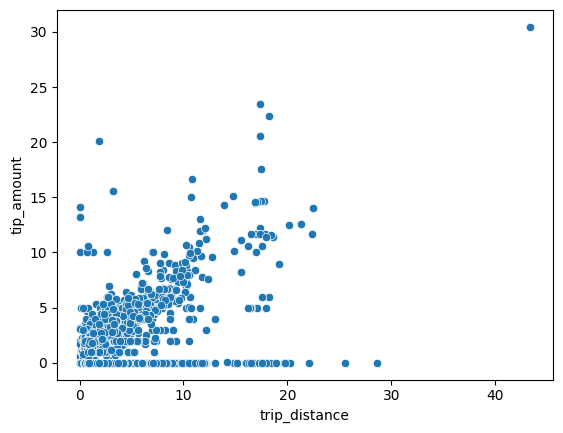

In [239]:
sns.scatterplot(x='trip_distance',y='tip_amount',data=df)